# This notebook attempts to speed up computations from earlier sensitivity notebook

In [1]:
import numpy as np, time
from typing import Tuple
import math
from scipy.special import erfcinv
from scipy.stats import chi2
from Include.preRun import pre_run
from Include.makeCaTable import make_ca_table
from init_settings import init_settings
from Include.plotAcqSearch import plotAcqSearch

In [2]:
#
#  Read datafile, return a complex numpy vector
#  

def readAcqData(settings, code_periods = None, skip = None, framing = False) -> np.ndarray:
    """
    read a datafile
    settings is the standard settings object.  We will use:
        fileName
        skipNumberOfBytes
        samplingFreq
        codeFreqBasis
        codeLength
        acqNonCohTime
        acqCoherentInt
    code_periods is the number of 1mS code periods we need
    skip is the number of samples in the datafile to skip
    """
    
    try:
        fid = open(settings.fileName, 'rb')
    except Exception as e:
        # Error while opening the data file.
        raise RuntimeError(f"Unable to read file {settings.fileName}: {e}")
    
    # Initialize the multiplier to adjust for the data type
    data_adapt_coeff = 1 if settings.fileType == 1 else 2
    
    # Move the starting point of processing. Can be used to start the
    # signal processing at any point in the data record (e.g. good for long
    # records or for signal processing in blocks).
    if skip == None:
        fid.seek(data_adapt_coeff * settings.skipNumberOfBytes, 0)
    else:
        fid.seek(data_adapt_coeff * skip, 0)
    
    # %% Acquisition ============================================================
    samples_per_code = int(round(settings.codeLength * settings.samplingFreq / settings.codeFreqBasis))
    # At least 42ms of signal are needed for fine frequency estimation

    code_len = (2*settings.acqCoherentInt)*(settings.acqNonCohTime)
    #code_len = max(42, settings.acqNonCohTime + 2)
    
    if code_periods == None:
        num_samples = data_adapt_coeff * code_len * samples_per_code
    else:
        num_samples = code_periods * code_len * samples_per_code
        
    # Read data for acquisition.
    if settings.dataType == 'schar':
        dtype = np.int8
    elif settings.dataType == 'short':
        dtype = np.int16
    elif settings.dataType == 'float':
        dtype = np.float32
    else:
        raise ValueError(f"Unsupported dataType: {settings.dataType}")
    data = np.fromfile(fid, dtype=dtype, count=num_samples)
    if data.size < num_samples:
        raise ValueError('Could not read enough data from the data file.')
    
    if data_adapt_coeff == 2:
        # For complex data, separate I and Q
        data_i = data[::2]
        data_q = data[1::2]
        data = data_i + 1j * data_q
    fid.close()
    # If the framing flag is set to be true, we fill 1mS of data down each column
    # and there is one column for each code period
    #
    if framing == True:
        data = data.reshape(-1, code_len)
    return (data)

In [3]:
settings = init_settings()
print (f'Data File: {settings.fileName}')
longdata = readAcqData(settings, framing = False)

Data File: /mnt/e/gnss_data/L1_IF20KHz_FS18MHz/L1_IF20KHz_FS18MHz.bin


## Define a class for the detector output

In [4]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional
import time
import numpy as np
from scipy import fft as sfft


@dataclass(slots=True)
class CACodeDetectionResult:
    """Container for C/A-code acquisition output."""
    success: bool
    prn: int
    n_coherent: int
    n_noncoherent: int
    detector: Optional[np.ndarray]   # shape: (n_freq_bins, 2*samples_per_code*n_coherent)
    freq_table: Optional[np.ndarray] # shape: (n_freq_bins,)
    runtime: float
    error_message: Optional[str] = None

    # ------------------------------------------------------------
    # Derived information methods
    # ------------------------------------------------------------
    def peak_value(self) -> Optional[float]:
        """
        Return the maximum value in the detector array, or None if unavailable.
        """
        if self.detector is None:
            return None
        return float(np.max(self.detector))

    def peak_location(self) -> Optional[dict]:
        """
        Return the indices and corresponding Doppler frequency of the detector peak.

        Returns
        -------
        dict with keys:
            'freq_index' : int
            'code_index' : int
            'doppler_hz' : float
            'value'      : float
        or None if no detector data is available.
        """
        if self.detector is None or self.freq_table is None:
            return None

        flat_index = int(np.argmax(self.detector))
        freq_index, code_index = np.unravel_index(flat_index, self.detector.shape)
        doppler_hz = float(self.freq_table[freq_index])
        value = float(self.detector[freq_index, code_index])
        return {
            "freq_index": freq_index,
            "code_index": code_index,
            "doppler_hz": doppler_hz,
            "value": value,
        }

### Define a function to do the detection

In [5]:

def detect_ca_sat(
    prn: int,
    long_data: np.ndarray,
    settings,
    show_status: bool = False,
    n_coherent: Optional[int] = None,
    n_noncoherent: Optional[int] = None,
) -> CACodeDetectionResult:
    """
    Attempt to detect the GPS C/A code for PRN `prn` in complex baseband `long_data`.

    Returns
    -------
    CACodeDetectionResult
        success, prn, n_coherent, n_noncoherent, detector (2D), freq_table (1D), runtime
    """
    start_time = time.time()
    if show_status:
        print(f"Beginning Detection of PRN {prn}")

    t_sample = 1.0 / settings.samplingFreq
    low_freq = -float(settings.acqSearchBand)
    high_freq = float(settings.acqSearchBand)

    if n_coherent is None:
        n_coherent = int(settings.acqCoherentInt)
    if n_noncoherent is None:
        n_noncoherent = int(settings.acqNonCohTime)

    if show_status:
        print(f"Coherent Integrations: {n_coherent}, Non-Coherent Integrations: {n_noncoherent}")

    # Samples per code and total sample requirement
    samples_per_code = int(round(settings.codeLength * settings.samplingFreq / settings.codeFreqBasis))
    num_codes = 2 * n_coherent * n_noncoherent
    total_samples = samples_per_code * num_codes

    # Ensure enough data
    if len(long_data) < total_samples:
        if show_status:
            print("Insufficient Data to perform acquisition")
            print(f"{total_samples} samples needed, received {len(long_data)}")
        return CACodeDetectionResult(
            success=False,
            prn=prn,
            n_coherent=n_coherent,
            n_noncoherent=n_noncoherent,
            detector=None,
            freq_table=None,
            runtime=time.time() - start_time,
            error_message="Insufficient Data",
        )

    # DC removal & scale
    rl = np.real(long_data)
    im = np.imag(long_data)
    rl -= np.mean(rl)
    im -= np.mean(im)
    max_sample = np.max(np.concatenate((rl, im)))
    long_data = ((0.5 / max_sample) * (rl + 1j * im)).astype(np.complex64)

    # Mix to baseband if needed
    if getattr(settings, "IF", 0.0) != 0.0:
        w = 2.0 * np.pi * t_sample * float(settings.IF)
        phase_points = np.arange(len(long_data), dtype=np.float32) * w
        lo_carrier = np.exp(-1j * phase_points).astype(np.complex64)
        long_data = (long_data * lo_carrier).astype(np.complex64)

    # PRN template (TD and FD)
    pn_code_samples = make_ca_table(prn, settings)
    zero_padding = np.zeros(samples_per_code * n_coherent, dtype=np.complex64)
    prn_template_td = np.concatenate((np.tile(pn_code_samples, n_coherent), zero_padding)).astype(np.complex64)
    prn_template_fd = np.conj(sfft.fft(prn_template_td))

    # Frequency grid and Doppler window
    freqs = np.fft.fftfreq(len(prn_template_td), t_sample)
    freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
    n_freq_bins = int(np.sum(freq_mask))

    # Center near 0 Hz
    initial_shift = (n_freq_bins - 1) // 2
    freq_table = np.roll(freqs, initial_shift)[:n_freq_bins]

    # Reshape input into non-coherent blocks (each: 2 * n_coherent codes)
    n_cols = 2 * samples_per_code * n_coherent
    data = (long_data[:total_samples]).reshape((n_noncoherent, n_cols))

    # Main convolution loop across Doppler bins
    detector = np.zeros((n_freq_bins, n_cols), dtype=np.float32)

    for noncoh_idx in range(n_noncoherent):
        if show_status:
            print(f"Noncoherent Integration {noncoh_idx}")
        coh_detector = np.zeros((n_freq_bins, n_cols), dtype=np.complex64)
        coh_data = data[noncoh_idx, :]

        this_data_fd = sfft.fft(coh_data)
        this_data_fd = np.roll(this_data_fd, initial_shift)

        for i in range(n_freq_bins):
            convolution_fd = this_data_fd * prn_template_fd
            coh_detector[i, :] = sfft.ifft(convolution_fd)
            this_data_fd = np.roll(this_data_fd, -1)

        detector += (np.abs(coh_detector) ** 2).astype(np.float32)

    # Normalize by number of noncoherent sums and samples per code
    detector = (detector / (n_noncoherent * samples_per_code)).astype(np.float32)

    return CACodeDetectionResult(
        success=True,
        prn=prn,
        n_coherent=n_coherent,
        n_noncoherent=n_noncoherent,
        detector=detector,
        freq_table=freq_table,
        runtime=time.time() - start_time,
    )

In [6]:
detection_results = detect_ca_sat(17, longdata, settings, n_coherent = 10, n_noncoherent = 10)
acq_matrix = detection_results.detector
runtime = detection_results.runtime
print (f"Runtime: {runtime}")
#plotAcqSearch(317, settings, acq_matrix)


Runtime: 21.290615797042847


In [7]:
import cupy as cp
import cupy.cuda.cudnn
import cupy.cuda.nccl
cp.show_config()
#x = cp.random.random(1_000_000, dtype=cp.float32)
#y = cp.fft.fft(x)  # quick sanity check
#print("OK:", y.shape, y.dtype)

OS                           : Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.39
Python Version               : 3.12.3
CuPy Version                 : 13.6.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 2.3.3
SciPy Version                : 1.16.2
Cython Build Version         : 3.0.12
Cython Runtime Version       : None
CUDA Root                    : /usr
nvcc PATH                    : /usr/bin/nvcc
CUDA Build Version           : 12090
CUDA Driver Version          : 13000
CUDA Runtime Version         : 12090 (linked to CuPy) / 12000 (locally installed)
CUDA Extra Include Dirs      : []
cuBLAS Version               : (available)
cuFFT Version                : 11001
cuRAND Version               : 10301
cuSOLVER Version             : (11, 4, 3)
cuSPARSE Version             : (available)
NVRTC Version                : (12, 0)
Thrust Version               : 200800
CUB Build Version            : 200800
Jitify Build Version         : <unknown>
cuDNN Build

In [8]:
# GPU variant: requires CuPy installed for your CUDA version (e.g., cupy-cuda12x)
# pip install "cupy-cuda12x"
import numpy as np
import time

try:
    import cupy as cp
    from cupyx.scipy import fft as csfft  # SciPy-like FFT API on GPU
except Exception as e:
    raise ImportError("CuPy is required for detect_ca_sat_gpu(). "
                      "Install the appropriate cupy-cudaXX wheel.") from e


def detect_ca_sat_gpu(
    prn: int,
    long_data: np.ndarray,
    settings,
    show_status: bool = False,
    n_coherent: int | None = None,
    n_noncoherent: int | None = None,
) -> CACodeDetectionResult:
    """
    GPU-accelerated (CUDA/CuPy) version of detect_ca_sat.
    FFTs and array ops run on the GPU; detector/freq_table are copied back to NumPy at the end.

    Returns a CACodeDetectionResult with NumPy arrays for compatibility.
    """
    start_time = time.time()
    if show_status:
        print(f"[GPU] Beginning Detection of PRN {prn}")

    # Resolve parameters
    t_sample = 1.0 / settings.samplingFreq
    low_freq = -float(settings.acqSearchBand)
    high_freq = float(settings.acqSearchBand)

    if n_coherent is None:
        n_coherent = int(settings.acqCoherentInt)
    if n_noncoherent is None:
        n_noncoherent = int(settings.acqNonCohTime)

    if show_status:
        print(f"[GPU] Coherent Integrations: {n_coherent}, Non-Coherent Integrations: {n_noncoherent}")

    # Samples per code and total requirement
    samples_per_code = int(round(settings.codeLength * settings.samplingFreq / settings.codeFreqBasis))
    n_cols = 2 * samples_per_code * n_coherent
    num_codes = 2 * n_coherent * n_noncoherent
    total_samples = samples_per_code * num_codes

    if len(long_data) < total_samples:
        if show_status:
            print("[GPU] Insufficient Data to perform acquisition")
            print(f"[GPU] {total_samples} samples needed, received {len(long_data)}")
        return CACodeDetectionResult(
            success=False,
            prn=prn,
            n_coherent=n_coherent,
            n_noncoherent=n_noncoherent,
            detector=None,
            freq_table=None,
            runtime=time.time() - start_time,
            error_message="Insufficient Data",
        )

    # ---- Move data to GPU and process entirely on device ----
    x = cp.asarray(long_data, dtype=cp.complex64)

    # DC removal & scale on GPU
    rl = cp.real(x)
    im = cp.imag(x)
    rl = rl - rl.mean()
    im = im - im.mean()
    max_sample = cp.maximum(rl.max(), im.max())
    x = ((0.5 / max_sample) * (rl + 1j * im)).astype(cp.complex64)

    # Mix to baseband if needed (GPU)
    IF = float(getattr(settings, "IF", 0.0))
    if IF != 0.0:
        w = cp.float32(2.0 * cp.pi * t_sample * IF)
        phase_points = cp.arange(x.size, dtype=cp.float32) * w
        lo_carrier = cp.exp(-1j * phase_points).astype(cp.complex64)
        x = (x * lo_carrier).astype(cp.complex64)

    # PRN template on GPU
    pn_code_samples = make_ca_table(prn, settings)  # likely NumPy
    pn = cp.asarray(pn_code_samples, dtype=cp.complex64)
    zero_padding = cp.zeros(samples_per_code * n_coherent, dtype=cp.complex64)
    prn_template_td = cp.concatenate((cp.tile(pn, n_coherent), zero_padding)).astype(cp.complex64)
    prn_template_fd = cp.conj(csfft.fft(prn_template_td))

    # Frequency grid and Doppler window on GPU
    freqs = cp.fft.fftfreq(prn_template_td.size, t_sample)
    freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
    n_freq_bins = int(freq_mask.sum().get())  # .get() to host int

    initial_shift = (n_freq_bins - 1) // 2
    freq_table_gpu = cp.roll(freqs, initial_shift)[:n_freq_bins]

    # Reshape input into non-coherent blocks (each: 2 * n_coherent codes)
    data = x[:total_samples].reshape(n_noncoherent, n_cols)

    # Detector on GPU (float32)
    detector_gpu = cp.zeros((n_freq_bins, n_cols), dtype=cp.float32)

    for noncoh_idx in range(n_noncoherent):
        if show_status:
            print(f"[GPU] Noncoherent Integration {noncoh_idx}")
        coh_detector = cp.zeros((n_freq_bins, n_cols), dtype=cp.complex64)
        coh_data = data[noncoh_idx, :]

        this_data_fd = csfft.fft(coh_data)
        this_data_fd = cp.roll(this_data_fd, initial_shift)

        # Sweep Doppler by rolling FD bins (same strategy as CPU path)
        for i in range(n_freq_bins):
            convolution_fd = this_data_fd * prn_template_fd
            coh_detector[i, :] = csfft.ifft(convolution_fd)
            this_data_fd = cp.roll(this_data_fd, -1)

        detector_gpu += (cp.abs(coh_detector) ** 2).astype(cp.float32)

    # Normalize (GPU)
    detector_gpu = (detector_gpu / (n_noncoherent * samples_per_code)).astype(cp.float32)

    # ---- Copy outputs back to host (NumPy) for your dataclass ----
    detector = cp.asnumpy(detector_gpu)
    freq_table = cp.asnumpy(freq_table_gpu)

    return CACodeDetectionResult(
        success=True,
        prn=prn,
        n_coherent=n_coherent,
        n_noncoherent=n_noncoherent,
        detector=detector,
        freq_table=freq_table,
        runtime=time.time() - start_time,
    )

In [9]:
gpu_results = detect_ca_sat_gpu(17, longdata, settings, n_coherent = 5, n_noncoherent = 10)

In [10]:
print (gpu_results)
gpu_matrix = gpu_results.detector

CACodeDetectionResult(success=True, prn=17, n_coherent=5, n_noncoherent=10, detector=array([[0.34786037, 0.321885  , 0.32905504, ..., 0.36630833, 0.3646232 ,
        0.36780274],
       [0.14934641, 0.13313812, 0.14796849, ..., 0.13520297, 0.14868289,
        0.13778639],
       [0.11605281, 0.10830019, 0.11982411, ..., 0.12248748, 0.12372366,
        0.11941188],
       ...,
       [0.30124703, 0.27618322, 0.2606829 , ..., 0.2700318 , 0.3411596 ,
        0.300892  ],
       [0.26360503, 0.2556352 , 0.25026357, ..., 0.28417054, 0.30336976,
        0.27497604],
       [0.42250386, 0.42751104, 0.42316106, ..., 0.42354107, 0.4090293 ,
        0.41870403]], shape=(141, 180000), dtype=float32), freq_table=array([-7000., -6900., -6800., -6700., -6600., -6500., -6400., -6300.,
       -6200., -6100., -6000., -5900., -5800., -5700., -5600., -5500.,
       -5400., -5300., -5200., -5100., -5000., -4900., -4800., -4700.,
       -4600., -4500., -4400., -4300., -4200., -4100., -4000., -3900.,
      

In [11]:
print (detection_results)
det_matrix = detection_results.detector
print (det_matrix.shape)

CACodeDetectionResult(success=True, prn=17, n_coherent=5, n_noncoherent=10, detector=array([[0.34786057, 0.32188505, 0.32905513, ..., 0.3663084 , 0.36462322,
        0.36780286],
       [0.14934653, 0.13313824, 0.1479686 , ..., 0.13520299, 0.14868294,
        0.13778648],
       [0.11605284, 0.10830026, 0.11982418, ..., 0.12248753, 0.12372369,
        0.11941196],
       ...,
       [0.30124706, 0.27618322, 0.26068282, ..., 0.27003175, 0.34115973,
        0.30089206],
       [0.26360524, 0.25563538, 0.25026375, ..., 0.28417084, 0.3033701 ,
        0.2749763 ],
       [0.42250463, 0.42751175, 0.42316192, ..., 0.42354184, 0.4090301 ,
        0.41870478]], shape=(141, 180000), dtype=float32), freq_table=array([-7000., -6900., -6800., -6700., -6600., -6500., -6400., -6300.,
       -6200., -6100., -6000., -5900., -5800., -5700., -5600., -5500.,
       -5400., -5300., -5200., -5100., -5000., -4900., -4800., -4700.,
       -4600., -4500., -4400., -4300., -4200., -4100., -4000., -3900.,
      

In [12]:
print (np.max(det_matrix - gpu_matrix))
print (np.max(det_matrix))
rms = np.sqrt(np.sum(abs(det_matrix-gpu_matrix)**2) / len(det_matrix))
print (f"RMS = {rms}")

3.8146973e-05
90.558365
RMS = 8.255228021880612e-05


In [9]:
#
#  This function seems to work well, and execute quickest of all so far.
#
import time
import numpy as np
import cupy as cp
#from cupyx.scipy.fft import fft as cp_fft, ifft as cp_ifft
from cupy.fft import fft as cp_fft, ifft as cp_ifft
from cupyx.scipy.fftpack import get_fft_plan  # plan reuse

def detect_ca_sat_gpu(
    prn: int,
    long_data: np.ndarray,
    settings,
    show_status: bool = False,
    n_coherent: int | None = None,
    n_noncoherent: int | None = None,
) -> CACodeDetectionResult:
    #
    #
    t0 = time.time()
    t_sample = 1.0 / settings.samplingFreq
    low_f  = -float(settings.acqSearchBand)
    high_f =  float(settings.acqSearchBand)
    if n_coherent    is None: n_coherent    = int(settings.acqCoherentInt)
    if n_noncoherent is None: n_noncoherent = int(settings.acqNonCohTime)

    samples_per_code = int(round(settings.codeLength * settings.samplingFreq / settings.codeFreqBasis))
    N = 2 * samples_per_code * n_coherent   # samples per coherent vector; IFFT length / columns
    B = n_noncoherent
    total_samples = samples_per_code * (2 * n_coherent * n_noncoherent)

    if len(long_data) < total_samples:
        return CACodeDetectionResult(False, prn, n_coherent, n_noncoherent, None, None, time.time()-t0, "Insufficient Data")

    # ---- Move + preprocess on GPU
    x = cp.asarray(long_data, dtype=cp.complex64)
    rl = x.real; im = x.imag
    rl -= rl.mean(); im -= im.mean()
    scale = cp.maximum(rl.max(), im.max())
    x = ((0.5 / scale) * (rl + 1j*im)).astype(cp.complex64, copy=False)

    IF = float(getattr(settings, "IF", 0.0))
    if IF != 0.0:
        w = cp.float32(2.0 * cp.pi * t_sample * IF)
        n = cp.arange(x.size, dtype=cp.float32)
        x *= cp.exp(-1j * w * n).astype(cp.complex64, copy=False)

    # ---- PRN template TD/FD
    # Move the PRN onto the GPU, then make a new vector that is
    # copy nCoherent copies and an equal length of zeros
    pn = cp.asarray(make_ca_table(prn, settings), dtype=cp.complex64)
    prn_td = cp.concatenate((cp.tile(pn, n_coherent),
                             cp.zeros(samples_per_code * n_coherent, dtype=cp.complex64)))
    prn_td = cp.ascontiguousarray(prn_td)
    with get_fft_plan(prn_td, value_type='C2C'):
        prn_fd_conj = cp.conj(cp_fft(prn_td))  # (N,)

    # ---- Doppler bins
    freqs = cp.fft.fftfreq(N, t_sample)
    mask = (freqs >= low_f) & (freqs <= high_f)
    F = int(mask.sum().get())   #get() method pulls the sum off the GPU and back to CPU
    initial_shift = (F - 1) // 2
    freq_table_gpu = cp.roll(freqs, initial_shift)[:F].copy()

    # ---- Reshape into B blocks (e.g. B = nNoncoherent) and FFT each (plan once)
    data = x[:total_samples].reshape(B, N)
    data = cp.ascontiguousarray(data)
    with get_fft_plan(data, axes=(1,), value_type='C2C'):
        X_fd = cp_fft(data, axis=1)  # (B, N), contiguous

    # ---- Precompute T_fd for bin 0 and a cheap per-bin update
    # Bin i corresponds to rolling by s = initial_shift - i (mod N).
    # We'll maintain a rolling view of prn_fd_conj using indices (no B×F×N tensors).
    base_idx = cp.arange(N, dtype=cp.int32)
    # start with s0 = initial_shift
    idx = (base_idx - initial_shift) % N
    # preallocate work buffers to avoid re-allocation costs
    conv_fd = cp.empty((B, N), dtype=cp.complex64)
    ifft_out = cp.empty((B, N), dtype=cp.complex64)
    detector_gpu = cp.zeros((F, N), dtype=cp.float32)
    #
    # We normally think about looping over the non-coherent integrations
    # and adding together matrixes several matrixes each of dimension [doppler][sample].
    # It turns out that is not the best approach on a GPU -it is fastest 
    # to loop over the doppler frequencies, and 
    # at the end of the loop perform all the no-coherent integrations 
    # for that doppler frequency.  This is because
    # n_noncoherent < n_frequencies, this minimizes the gather time
    # at the end of the loop.
    #
    # One cuFFT plan for the (B, N) inverse transforms, reused across all bins
    with get_fft_plan(ifft_out, axes=(1,), value_type='C2C'):
        for i in range(F):
            # Gather shifted template spectrum for this Doppler bin
            T_fd = prn_fd_conj[idx]          # (N,)
            # Broadcast multiply (B, N) * (N,) -> (B, N)
            cp.multiply(X_fd, T_fd, out=conv_fd)
            # Batched IFFT over N for all B blocks
            ifft_out[...] = cp_ifft(conv_fd, axis=1)
            # Power & accumulate over B
            # detector row i: sum |ifft_out|^2 across B
            detector_gpu[i] = cp.sum((ifft_out.real * ifft_out.real + ifft_out.imag * ifft_out.imag), axis = 0, dtype = cp.float32)
            #power = cp.abs(ifft_out)**2
            #detector_gpu[i] = power.sum(axis=0).astype(cp.float32)
            # Update index for next bin: shift right by 1 (equivalent to roll by -1 later)
            idx = (idx + 1) % N

    # Normalize
    detector_gpu *= (1.0 / (B * samples_per_code))

    detector = cp.asnumpy(detector_gpu)
    freq_table = cp.asnumpy(freq_table_gpu)
    return CACodeDetectionResult(True, prn, n_coherent, n_noncoherent, detector, freq_table, time.time()-t0)

In [10]:
gpu_results_new = detect_ca_sat_gpu(17, longdata, settings, n_coherent = 10, n_noncoherent = 10)
print (gpu_results_new)
gpu_matrix = gpu_results_new.detector

CACodeDetectionResult(success=True, prn=17, n_coherent=10, n_noncoherent=10, detector=array([[0.9604418 , 1.0009034 , 0.9979234 , ..., 0.8933247 , 0.92158943,
        1.0121843 ],
       [0.6549029 , 0.6476654 , 0.6370943 , ..., 0.6201486 , 0.6977768 ,
        0.72734916],
       [0.652348  , 0.5872303 , 0.55636406, ..., 0.65308654, 0.68207186,
        0.6722321 ],
       ...,
       [0.4000988 , 0.380408  , 0.3744726 , ..., 0.41692552, 0.35285804,
        0.34094098],
       [0.38422903, 0.35502324, 0.3644618 , ..., 0.41028377, 0.3948506 ,
        0.36060795],
       [0.50825155, 0.43537188, 0.42896998, ..., 0.5961454 , 0.60287267,
        0.52682066]], shape=(281, 360000), dtype=float32), freq_table=array([-7000., -6950., -6900., -6850., -6800., -6750., -6700., -6650.,
       -6600., -6550., -6500., -6450., -6400., -6350., -6300., -6250.,
       -6200., -6150., -6100., -6050., -6000., -5950., -5900., -5850.,
       -5800., -5750., -5700., -5650., -5600., -5550., -5500., -5450.,
     

In [85]:
#
#  New approach - Changed the for loop to go over n_noncoherent
#
import time
import numpy as np
import cupy as cp
#from cupy.fft import fft as cp_fft, ifft as cp_ifft
from cupyx.scipy.fft import fft as cp_fft, ifft as cp_ifft
from cupyx.scipy.fftpack import get_fft_plan  # plan reuse

def detect_ca_sat_gpu(
    prn: int,
    long_data: np.ndarray,
    settings,
    show_status: bool = False,
    n_coherent: int | None = None,
    n_noncoherent: int | None = None,
) -> CACodeDetectionResult:
    #
    #
    t0 = time.time()
    t_sample = 1.0 / settings.samplingFreq
    low_f  = -float(settings.acqSearchBand)
    high_f =  float(settings.acqSearchBand)
    if n_coherent    is None: n_coherent    = int(settings.acqCoherentInt)
    if n_noncoherent is None: n_noncoherent = int(settings.acqNonCohTime)

    samples_per_code = int(round(settings.codeLength * settings.samplingFreq / settings.codeFreqBasis))
    N = 2 * samples_per_code * n_coherent   # samples per coherent vector; IFFT length / columns
    B = n_noncoherent
    total_samples = samples_per_code * (2 * n_coherent * n_noncoherent)

    if len(long_data) < total_samples:
        return CACodeDetectionResult(False, prn, n_coherent, n_noncoherent, None, None, time.time()-t0, "Insufficient Data")

    # ---- Move + preprocess on GPU
    x = cp.asarray(long_data, dtype=cp.complex64)
    rl = x.real; im = x.imag
    rl -= rl.mean(); im -= im.mean()
    scale = cp.maximum(rl.max(), im.max())
    x = ((0.5 / scale) * (rl + 1j*im)).astype(cp.complex64, copy=False)

    IF = float(getattr(settings, "IF", 0.0))
    if IF != 0.0:
        w = cp.float32(2.0 * cp.pi * t_sample * IF)
        n = cp.arange(x.size, dtype=cp.float32)
        x *= cp.exp(-1j * w * n).astype(cp.complex64, copy=False)

    
    # ---- Compute Doppler bins, 2D matrix size, shifts
    freqs = cp.fft.fftfreq(N, t_sample)
    mask = (freqs >= low_f) & (freqs <= high_f)
    F = int(mask.sum().get())   #get() method pulls the sum off the GPU and back to CPU
    initial_shift = (F - 1) // 2
    freq_table_gpu = cp.roll(freqs, initial_shift)[:F].copy()
    #
    # Move the Frequency table onto the CPU
    # It will be returned when the function completes
    freq_table = cp.asnumpy(freq_table_gpu)
    # pre-allocate memory for an empty array for the final result
    detector = np.empty((F, N))
    # ---- PRN code template TD/FD
    # Move the PRN onto the GPU, then make a new vector that is
    # nCoherent copies and an equal length of zeros
    pn = cp.asarray(make_ca_table(prn, settings), dtype=cp.complex64)
    prn_td = cp.concatenate((cp.tile(pn, n_coherent),
                             cp.zeros(samples_per_code * n_coherent, dtype=cp.complex64)))
    prn_td = cp.ascontiguousarray(prn_td)
    with get_fft_plan(prn_td, value_type='C2C'):
        prn_fd_conj1 = cp.conj(cp_fft(prn_td))  # (N,)
    prn_fd_conj1 = cp.roll(prn_fd_conj1, initial_shift)
    #
    # The following 3 steps efficiently re-shape the prn_fd_conj matrix into
    # size (nfreq_bins, N samples), with a 1 sample shift between them
    #
    prn_fd_conj_ext = cp.ascontiguousarray(cp.concatenate((prn_fd_conj1, prn_fd_conj1[:F])))
    element_bytes = prn_fd_conj1.itemsize
    prn_fd_conj = cp.lib.stride_tricks.as_strided(prn_fd_conj_ext,shape = (F, N), strides = (element_bytes, element_bytes))
    
    # ---- Reshape Sample Data into B blocks (e.g. B = nNoncoherent) and FFT each (plan once)
    data = x[:total_samples].reshape(B, N)
    data = cp.ascontiguousarray(data)
    with get_fft_plan(data, axes=(1,), value_type='C2C'):
        X_fd = cp_fft(data, axis=1)  # (B, N), contiguous

    # ---- Precompute T_fd for bin 0 and a cheap per-bin update
    # Bin i corresponds to rolling by s = initial_shift - i (mod N).
    # We'll maintain a rolling view of prn_fd_conj using indices (no B×F×N tensors).
    #base_idx = cp.arange(N, dtype=cp.int32)
    # start with s0 = initial_shift
    #idx = (base_idx - initial_shift) % N
    # preallocate work buffers to avoid re-allocation costs
    conv_fd = cp.empty((F, N), dtype=cp.complex64)
    ifft_out = cp.empty((F, N), dtype=cp.complex64)
    power = cp.empty((F,N), dtype=cp.float32)
    #
    # Check this
    detector_gpu = cp.zeros((F, N), dtype=cp.float32)
    #
    # Check the initialization process time
    cp.cuda.Device().synchronize()
    print (f'Time to initialize: {time.time()-t0}')

    # One cuFFT plan for the (B, N) inverse transforms, reused across all bins
    #my_fft_plan = get_fft_plan(ifft_out, axes=(1,0), value_type = 'C2C')
    with get_fft_plan(ifft_out, axes=(1,), value_type='C2C'):
        for i in range(n_noncoherent):
            # Broadcast multiply (nFreqs, N)
            #t1 = time.time()
            cp.multiply(prn_fd_conj, X_fd[i, :], out=conv_fd)
            conv_fd = cp.ascontiguousarray(conv_fd)
            #t2 = time.time()
            # Batched IFFT over N for all B blocks
            ifft_out[...] = cp_ifft(conv_fd, axis = 1)
            #t3 = time.time()
            #print (f"Multiply time: {t2 - t1}, IFFT time {t3 - t1}, shape = {conv_fd.shape}")
            # Power & accumulate over B
            # detector row i: sum |ifft_out|^2 across B
            power = cp.abs(ifft_out)**2
            cp.add(power, detector_gpu, out=detector_gpu)
            cp.cuda.Device().synchronize()
            print (f"Elapsed time: {time.time() - t0}")

    # Normalize
    print (f"Loop completed in {time.time() - t0} seconds")
    cp.multiply(detector_gpu, (1.0 / (B * samples_per_code)), out = detector_gpu)
    print (f"beginning synchronization {time.time() - t0}")
    #detector_gpu *= (1.0 / (B * samples_per_code))
    cp.cuda.Device().synchronize()
    print (f"All processes synchronized {time.time() - t0}")
    t4 = time.time()

    detector = cp.asnumpy(detector_gpu)
    print (detector_gpu.shape)
    print (f"Copy time = {time.time() - t4}")
    #detector = np.zeros(detector_gpu.shape)
    return CACodeDetectionResult(True, prn, n_coherent, n_noncoherent, detector, freq_table, time.time()-t0)

In [86]:
gpu_results_new = detect_ca_sat_gpu(17, longdata, settings, n_coherent = 10, n_noncoherent = 10)
print (gpu_results_new)
gpu_matrix = gpu_results_new.detector

Time to initialize: 0.21286273002624512
Elapsed time: 0.4887573719024658
Elapsed time: 0.711493730545044
Elapsed time: 0.9852800369262695
Elapsed time: 1.207183599472046
Elapsed time: 1.4804999828338623
Elapsed time: 1.7022550106048584
Elapsed time: 1.9760262966156006
Elapsed time: 2.199251174926758
Elapsed time: 2.4719600677490234
Elapsed time: 2.6942386627197266
Loop completed in 2.6943070888519287 seconds
beginning synchronization 2.6944386959075928
All processes synchronized 2.6965010166168213
(281, 360000)
Copy time = 0.1714162826538086
CACodeDetectionResult(success=True, prn=17, n_coherent=10, n_noncoherent=10, detector=array([[0.9604418 , 1.0009034 , 0.9979234 , ..., 0.89332455, 0.92158943,
        1.0121843 ],
       [0.6549029 , 0.64766544, 0.6370944 , ..., 0.6201486 , 0.69777685,
        0.72734916],
       [0.6523479 , 0.5872303 , 0.556364  , ..., 0.65308666, 0.68207186,
        0.67223215],
       ...,
       [0.40009883, 0.380408  , 0.37447262, ..., 0.41692552, 0.35285798,

In [39]:
plotAcqSearch(417, settings, gpu_matrix)

PosixPath('/home/joe/cu_gnss/cugnss-python/plots/coarse_acquisition_PRN_417.jpg')

In [17]:
import time
import numpy as np
import cupy as cp
from cupy.fft import fft as cp_fft, ifft as cp_ifft
from cupyx.scipy.fftpack import get_fft_plan

def detect_ca_sat_gpu(
    prn: int,
    long_data: np.ndarray,
    settings,
    show_status: bool = False,
    n_coherent: int | None = None,
    n_noncoherent: int | None = None,
) -> CACodeDetectionResult:
    t0 = time.time()
    t_sample = 1.0 / settings.samplingFreq
    low_f  = -float(settings.acqSearchBand)
    high_f =  float(settings.acqSearchBand)
    if n_coherent    is None: n_coherent    = int(settings.acqCoherentInt)
    if n_noncoherent is None: n_noncoherent = int(settings.acqNonCohTime)

    samples_per_code = int(round(settings.codeLength * settings.samplingFreq / settings.codeFreqBasis))
    N = 2 * samples_per_code * n_coherent   # IFFT length / columns
    B = n_noncoherent
    total_samples = samples_per_code * (2 * n_coherent * n_noncoherent)

    if len(long_data) < total_samples:
        return CACodeDetectionResult(False, prn, n_coherent, n_noncoherent, None, None, time.time()-t0, "Insufficient Data")

    # ---- Move + preprocess on GPU
    x = cp.asarray(long_data, dtype=cp.complex64)
    rl = x.real; im = x.imag
    rl -= rl.mean(); im -= im.mean()
    scale = cp.maximum(rl.max(), im.max())
    x = ((0.5 / scale) * (rl + 1j*im)).astype(cp.complex64, copy=False)

    IF = float(getattr(settings, "IF", 0.0))
    if IF != 0.0:
        w = cp.float32(2.0 * cp.pi * t_sample * IF)
        n = cp.arange(x.size, dtype=cp.float32)
        x *= cp.exp(-1j * w * n).astype(cp.complex64, copy=False)

    # ---- PRN template TD/FD
    pn = cp.asarray(make_ca_table(prn, settings), dtype=cp.complex64)
    prn_td = cp.concatenate((cp.tile(pn, n_coherent),
                             cp.zeros(samples_per_code * n_coherent, dtype=cp.complex64)))
    prn_td = cp.ascontiguousarray(prn_td)
    with get_fft_plan(prn_td, value_type='C2C'):
        prn_fd_conj = cp.conj(cp_fft(prn_td))  # (N,)

    # ---- Doppler bins
    freqs = cp.fft.fftfreq(N, t_sample)
    mask = (freqs >= low_f) & (freqs <= high_f)
    F = int(mask.sum().get())
    initial_shift = (F - 1) // 2
    freq_table_gpu = cp.roll(freqs, initial_shift)[:F].copy()

    # ---- Reshape into B blocks and FFT each (plan once)
    data = cp.ascontiguousarray(x[:total_samples].reshape(B, N))
    with get_fft_plan(data, axes=(1,), value_type='C2C'):
        X_fd = cp_fft(data, axis=1)  # (B, N)

    # ---- Work buffers
    conv_fd  = cp.empty((B, N), dtype=cp.complex64)
    ifft_out = cp.empty((B, N), dtype=cp.complex64)
    detector_gpu = cp.zeros((F, N), dtype=cp.float32)

    # ---- One cuFFT plan for all (B,N) IFFTs
    with get_fft_plan(ifft_out, axes=(1,), value_type='C2C'):
        shift = initial_shift
        for i in range(F):
            # Shift template spectrum for this Doppler bin
            # Note: negative sign keeps same direction as earlier roll-by-1 per bin
            T_fd = cp.roll(prn_fd_conj, -shift)     # (N,) copy
            # Broadcast multiply and IFFT
            cp.multiply(X_fd, T_fd, out=conv_fd)    # (B,N)
            ifft_out[...] = cp_ifft(conv_fd, axis=1)
            # Noncoherent power sum over B blocks
            detector_gpu[i] = (cp.abs(ifft_out)**2).sum(axis=0, dtype=cp.float32)
            # advance Doppler shift
            shift = (shift + 1) % N

    # Normalize
    detector_gpu *= (1.0 / (B * samples_per_code))

    detector   = cp.asnumpy(detector_gpu)
    freq_table = cp.asnumpy(freq_table_gpu)
    return CACodeDetectionResult(True, prn, n_coherent, n_noncoherent, detector, freq_table, time.time()-t0)

In [18]:
gpu_results_new = detect_ca_sat_gpu(17, longdata, settings, n_coherent = 5, n_noncoherent = 10)
print (gpu_results_new)
gpu_matrix = gpu_results_new.detector

CACodeDetectionResult(success=True, prn=17, n_coherent=5, n_noncoherent=10, detector=array([[0.34786037, 0.321885  , 0.32905504, ..., 0.36630833, 0.36462322,
        0.36780274],
       [0.4300179 , 0.41913372, 0.4142896 , ..., 0.36951903, 0.36328393,
        0.4261966 ],
       [0.34222108, 0.28212827, 0.27339506, ..., 0.37327987, 0.33882165,
        0.37371185],
       ...,
       [0.11101912, 0.12382203, 0.13599713, ..., 0.07203145, 0.09747507,
        0.10626945],
       [0.14874715, 0.13192186, 0.1450786 , ..., 0.14963967, 0.16818142,
        0.1703009 ],
       [0.16784184, 0.13658924, 0.15606616, ..., 0.12445568, 0.16283703,
        0.1743266 ]], shape=(141, 180000), dtype=float32), freq_table=array([-7000., -6900., -6800., -6700., -6600., -6500., -6400., -6300.,
       -6200., -6100., -6000., -5900., -5800., -5700., -5600., -5500.,
       -5400., -5300., -5200., -5100., -5000., -4900., -4800., -4700.,
       -4600., -4500., -4400., -4300., -4200., -4100., -4000., -3900.,
      

In [ ]:
#print (detectionResults)
runtime = detectionResults["runtime"]
print (f'Completed in {runtime} seconds')
max_location = detectionResults["index"]
detectArray = detectionResults["detector"]
sig = detectionResults["signalDetected"]
mean = detectionResults["mean"]
threshold = detectionResults["threshold"]
maxVal = detectionResults["maxValue"]


print (f'Signal Detected: {sig}')
print (f'max_location: {max_location}')
print (f'Maximum Correlation Value: {maxVal}')
print (f'Threshold Value: {threshold}')
print (f'Peak / Threshold: {maxVal / threshold}')
print (f'Mean Value: {mean:.2e}')

In [8]:
plotAcqSearch(203, settings, detectArray)

PosixPath('/home/joe/cu_gnss/cugnss-python/plots/coarse_acquisition_PRN_203.jpg')

## Now that we've got a function, let's run it against a hard data set

In [9]:

from new_settings import init_settings
newSettings = init_settings()
print (f'Data File: {newSettings.fileName}, Data Rate: {newSettings.samplingFreq}')
indoorData = readAcqData(newSettings, framing = False)
print (f'{indoorData.shape}')

Data File: /mnt/e/gnss_data/GNSSL1testSet-AeroN453-fs8_00-if0_02.bin, Data Rate: 8000000.0
(3200000,)


In [10]:
sv = []
for k in range(32):
    thisResult = detectCASat(k+1, indoorData, newSettings, nCoherent = 10, nNonCoherent = 10, pfa = 0.01)
    detected = thisResult["signalDetected"]
    print (f'Satellite {k+1} Signal Detected: {detected}')
    sv.append(thisResult)

Satellite 1 Signal Detected: False
Satellite 2 Signal Detected: False
Satellite 3 Signal Detected: False
Satellite 4 Signal Detected: False
Satellite 5 Signal Detected: False
Satellite 6 Signal Detected: False
Satellite 7 Signal Detected: False
Satellite 8 Signal Detected: True
Satellite 9 Signal Detected: False
Satellite 10 Signal Detected: False
Satellite 11 Signal Detected: False
Satellite 12 Signal Detected: False
Satellite 13 Signal Detected: False
Satellite 14 Signal Detected: False
Satellite 15 Signal Detected: True
Satellite 16 Signal Detected: False
Satellite 17 Signal Detected: False
Satellite 18 Signal Detected: False
Satellite 19 Signal Detected: False
Satellite 20 Signal Detected: False
Satellite 21 Signal Detected: False
Satellite 22 Signal Detected: False
Satellite 23 Signal Detected: False
Satellite 24 Signal Detected: False
Satellite 25 Signal Detected: False
Satellite 26 Signal Detected: False
Satellite 27 Signal Detected: False
Satellite 28 Signal Detected: False
Sat

Text(0.5, 1.0, 'Signal Strength of Satellites')

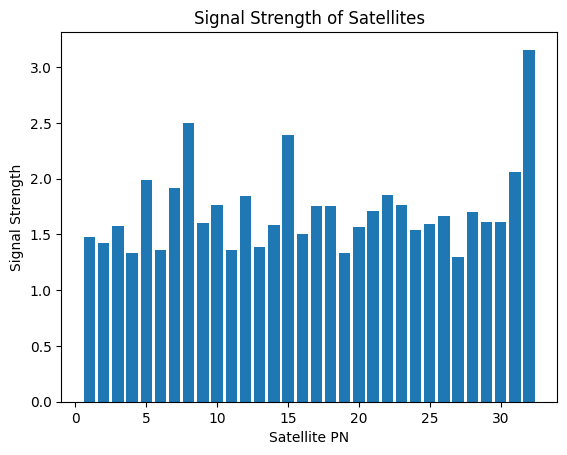

In [28]:
import matplotlib.pyplot as plt
sigStrength = np.zeros(32)
satNum = np.arange(32) + 1
for i in satNum:
    sigStrength[i-1] = sv[i-1]["maxValue"]
plt.bar(satNum, sigStrength)
plt.xlabel("Satellite PN")
plt.ylabel("Signal Strength")
plt.title("Signal Strength of Satellites")

In [31]:
p = 15
detectArray = sv[p-1]["detector"]
plotAcqSearch(300+p, newSettings, detectArray)

PosixPath('/home/joe/cu_gnss/cugnss-python/plots/coarse_acquisition_PRN_315.jpg')

In [ ]:
from scipy.stats import chi2
nCoherent = 5
nNonCoherent = 5
print (detectArray.size)
#variance = np.var(detectArray)
# This is an attempt to estimate the mean under no-signal conditions
# Assume signal is present in only a few cells, and most cells are noise.
# Average across rows - most rows will be noise, and they'll be pretty consistent.  
# If we take the median of those cells, it should give us a good estimate of median under
# No-signal conditions.
row_mean = np.mean(detectArray, axis = 1)
meanval = np.median(row_mean)
sigma_sq = meanval / nCoherent
medianval = np.median(detectArray)
maxval = np.max(detectArray)
pfa = 0.001 * (1/detectArray.size)
gamma = math.sqrt(2) * chi2.isf(pfa, 2*nCoherent)
print (f' max = {maxval}\n mean= {meanval}\n median= {medianval}\n variance= {variance} \n pfa = {pfa} \n gamma = {gamma}')
threshold = (sigma_sq / nNonCoherent) * gamma
print (f'Threshold = {threshold}')

In [ ]:
plotAcqSearch(99, settings, detectArray)

In [ ]:
nCoherent = 5
nNonCoherent = 5
pFA = 0.001

sv23_Results = detectCASat(23, longdata, settings, nCoherent = nCoherent, nNonCoherent = nNonCoherent, pfa=pFA)

detectArray = sv23_Results["detector"]
signalDetected = sv23_Results["signalDetected"]
maxValue = sv23_Results["maxValue"]
threshold = sv23_Results["threshold"]
print (f'Signal Detected = {signalDetected}')
print (f'Max Peak = {maxValue}')
print (f'Threshold Value = {threshold}')
print (f'DetectArray shape = {detectArray.shape}')
#variance = np.var(detectArray)


In [ ]:
# This is an attempt to estimate the mean under no-signal conditions (H0 condition)
# Assume signal is present in only a few cells, and most cells are noise.
# Average across rows - most rows will be noise, and they'll be pretty consistent.  
# If we take the median of those cells, it should give us a good estimate of median under
# No-signal conditions.
row_mean = np.mean(detectArray, axis = 1)
meanval = np.median(row_mean)
sigma_sq = meanval / nCoherent
medianval = np.median(detectArray)
maxval = np.max(detectArray)
#
# We want pfa to reflect the possibility of an error in this measurement
# there are len(detectArray) numbers we're going to evaluate
pfa = 0.05 / len(detectArray)
gamma = math.sqrt(2) * chi2.isf(pfa, 2*nCoherent)
print (f' max = {maxval}\n mean= {meanval}\n sigma square = {sigma_sq}\n  \n pfa = {pfa} \n gamma = {gamma}')
threshold = sigma_sq * gamma
print (f'Threshold = {threshold}')


In [ ]:
freq_list = sv23_Results["freqtable"]
plotAcqSearch(101, settings, detectArray)

In [ ]:
from scipy.stats import chi2
nCoherent = 5
nNonCoherent = 10
pfa = 0.05
sample_variance = mean / nCoherent
erf = chi2.isf(pfa, 2*nCoherent)
print (f'erf = {erf}')

threshold = (gamma / nNonCoherent )* math.sqrt(sample_variance)
print (f'gamma = {gamma}, \nthreshold = {threshold}')

In [ ]:
detected = sv23_Results ["signalDetected"]
mean = sv23_Results["mean"]
variance = sv23_Results["var"]
sdev = math.sqrt(variance)
threshold = sv23_Results["threshold"]
maxVal = sv23_Results["maxValue"]

print (f'Signal Detected: {sig}')
print (f'Peak Value = {maxVal}')
print (f'Signal Threshold: {threshold}')
print (f'Peak / Threshold: {maxVal / threshold}')
print (f'Threshold / sdev: {threshold / sdev}')
print (f'Mean Value: {mean:.2e}, standard deviation: {sdev:.2e}')
print (f'peak / threshold ratio: {maxVal / threshold}')
print (f'(peak - mean) / standard dev: {((maxVal - mean) / sdev)}')

In [ ]:
sv23_matrix = sv23_Results["detector"]
plotAcqSearch(101, settings, sv23_matrix)